<a href="https://colab.research.google.com/github/PhuongAnh2212/CS313Assignment2/blob/main/GRU_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Recurrent Neural Network (RNN) {-}

This assignment aims at familiarizing you with training and testing the RNN neural network for an image classification task. You will go through the process of loading data, preprocessing images, building the RNN model, and evaluating its performance.

The assignment rqeuirements include:
- **3.1 (1 point)** Load the dataset.
- **3.2 (1 point)** Analyze and process the dataset.
- **3.3 (2 points)** Construct an RNN model using GRU (Gated Recurrent Unit) instead of LSTM, as demonstrated in the demo code (https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU). Train and evaluate the model’s performance on the test set.
- **3.4 (2 points)** Construct an RNN model using Bidirectional LSTM (BiLSTM, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Train and evaluate the model’s performance on the test set.
- **3.5 (2 points)** Construct an RNN model using Bidirectional GRU (BiGRU, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Train and evaluate the model’s performance on the test set.
- **3.6 (2 points)** Compare the accuracy and runtime efficiency among LSTM, GRU, BiLSTM, and BiGRU models. Provide comments and observations on the performance of each model variant.

The dataset you will be working on is imdb_reviews. This dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a positive or negative sentiment. Reference: http://ai.stanford.edu/~amaas/data/sentiment/

Each data sample contains:
- label (tf.int64)
- text (tf.string)

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment3-notebook.ipynb: Jupyter notebook containing source code.

The submission folder is named DL4AI-\<StudentID>-Assignment3 (e.g., DL4AI-2012345-Assigment3) and then compressed with the same name.

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. The model accuracy on the test set is one of the most important evaluation criteria. Therefore try to push it as high as possible. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

# Download tensorflow datasets
!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [18]:
# Load the IMDB movie review dataset, return text (movie review) and label (positive/negative)
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:90%]', 'train[90%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Training set:  22500 samples
Validation set:  2500 samples
Test set:  25000 samples


In [3]:
# Show same samples in the training set
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [4]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = tf.convert_to_tensor(list(map(lambda x: x[0], train_numpy)), dtype=tf.string) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = tf.convert_to_tensor(list(map(lambda x: x[0], val_numpy)), dtype=tf.string) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = tf.convert_to_tensor(list(map(lambda x: x[0], test_numpy)), dtype=tf.string) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


In [5]:
### TextVectorization layer maps text features to integer sequences.
# Set vocabulary size for the training data
VOCAB_SIZE = 1000

# Initialize the TextVectorization layer for raw text encoding
text_encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # Maximum size of the vocabulary

# Feed training text to adapt() method to calculate the layer's vocabulary
text_encoder.adapt(X_train)

In [6]:
# Show the first 20 tokens. After the padding ('') and unknown ([UNK]) tokens they're sorted by frequency.
vocab = np.array(text_encoder.get_vocabulary()) # Get the vocabulary of the training set after the adaptation
print("Vocabulary size:", vocab.shape)
vocab[:20] # Show the first 20 tokens (sorted by frequency) in the vocabulary

Vocabulary size: (1000,)


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [7]:
### Example of how a text vectorization layer works. It maps strings to integers.

# Create the model that uses the text vectorization layer
model_encoder = tf.keras.models.Sequential()

# Creating an explicit input layer.
# It needs to have a shape of (1,) (because we need to guarantee that there is exactly one string input per batch),
model_encoder.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first (unique) layer in the model is the vectorization layer.
# After this layer, we have a tensor of shape (batch_size, max_len) containing vocab indices.
model_encoder.add(text_encoder)

# The model can map strings to integers, and you can add an embedding layer to map these integers to learned embeddings.
test_data = [["I want to drink"], ["I do not want to eat but I want to sleep"]]
test_data = tf.convert_to_tensor(test_data, dtype=tf.string)
model_encoder.predict(test_data)

# Note: The tensors of indices are zero-padded to the longest sequence in the batch,
# to make sure that all tensors of indices have the same size (for batching purpose).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


array([[ 10, 179,   6,   1,   0,   0,   0,   0,   0,   0,   0],
       [ 10,  79,  22, 179,   6,   1,  19,  10, 179,   6,   1]])

In [8]:
# Note: the vectorization process is not completely reversible due to the limited vocabulary size
print("Original: ", X_train[0])
print()
print("Round-trip: ", " ".join(vocab[text_encoder(X_train[0]).numpy()]))

Original:  tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)

Round-trip:  this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous sto

# GRU

In [23]:
import tensorflow as tf

# Initialize a sequential model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    text_encoder,  # Text encoder layer, e.g., TextVectorization layer
    tf.keras.layers.Embedding(
        input_dim=len(text_encoder.get_vocabulary()),  # Vocabulary size
        output_dim=64,  # Size of the embedding vector
        mask_zero=True  # Mask padding
    ),
    tf.keras.layers.Dropout(0.3),  # Dropout layer after embedding with 30% dropout rate
    tf.keras.layers.GRU(units=64),  # Replaced LSTM with GRU layer
    tf.keras.layers.Dropout(0.3),  # Dropout layer after GRU with 30% dropout rate
    tf.keras.layers.Dense(64, activation='relu'),  # Dense layer
    tf.keras.layers.Dropout(0.3),  # Dropout layer after Dense layer with 30% dropout rate
    tf.keras.layers.Dense(1, activation='sigmoid')  # Classification output
])

# Summarize the model
model.summary()

# Check if the layers after the Embedding supports masking
print([layer.supports_masking for layer in model.layers])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 64)            │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,185 (364.00 KB)

 Trainable params: 93,185 (364.00 KB)

 Non-trainable params: 0 (0.00 B)

[False, True, True, True, True, True, True, True]


In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping callback with patience of 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,  # Smaller batch size can sometimes improve generalization
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Include the early stopping callback
)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.6001 - loss: 0.6451 - val_accuracy: 0.6694 - val_loss: 0.6042
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.7387 - loss: 0.5282 - val_accuracy: 0.8020 - val_loss: 0.4504
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.8406 - loss: 0.3820 - val_accuracy: 0.8572 - val_loss: 0.3415
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.8657 - loss: 0.3329 - val_accuracy: 0.8656 - val_loss: 0.3216
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.8709 - loss: 0.3200 - val_accuracy: 0.8748 - val_loss: 0.3096
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.8845 - loss: 0.2859 - val_accuracy: 0.8602 - val_loss: 0.3230
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.8932 - loss: 0.2667 - val_accuracy: 0.8776 - val_loss: 0.3063
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.8995 - loss: 0.2499 - val_accu

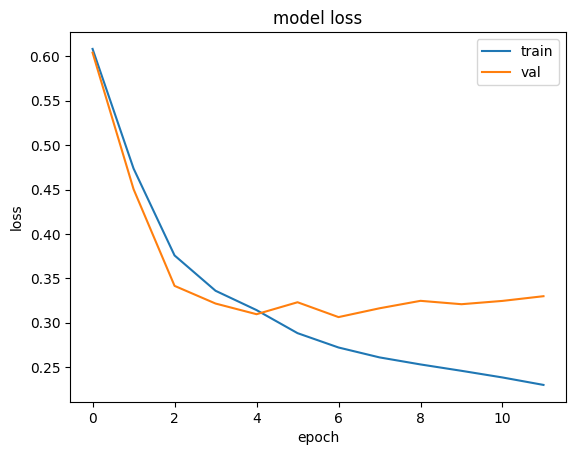

In [25]:
# Visualize the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

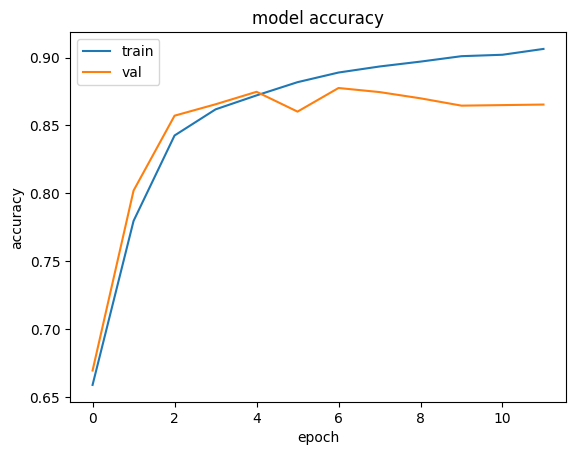

In [26]:
# Visualize the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 121ms/step - accuracy: 0.8744 - loss: 0.3056
Test Loss: 0.299387663602829
Test Accuracy: 0.8755599856376648


In [28]:
# Make prediction on a new data sample
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
sample_reviews = tf.convert_to_tensor(sample_reviews, dtype=tf.string)
predictions = model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
[0.8780311]
[0.07723522]


#